# Importing Liberaries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
# from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

Here we have 4 csv data files which we are going to use for building recomendation engine based on **cosine similarity**

# Reading CSV files

In [2]:
apps = pd.read_csv('apps.tsv', delimiter='\t',encoding='utf-8')
user_history = pd.read_csv('user_history.tsv', delimiter='\t',encoding='utf-8')
jobs = pd.read_csv('jobs.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)
users = pd.read_csv('users.tsv' ,delimiter='\t',encoding='utf-8')
test_users = pd.read_csv('test_users.tsv', delimiter='\t',encoding='utf-8')

b'Skipping line 122433: expected 11 fields, saw 12\n'
b'Skipping line 602576: expected 11 fields, saw 12\n'
b'Skipping line 990950: expected 11 fields, saw 12\n'


# Apps Data

In [3]:
apps

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748
...,...,...,...,...,...
1603106,1472089,7,Train,2012-06-23 16:06:03.087,573732
1603107,1472089,7,Train,2012-06-25 23:20:35.603,39401
1603108,1472089,7,Train,2012-04-30 14:01:42.52,175198
1603109,1472089,7,Train,2012-04-30 13:52:45.823,1073263


In [4]:
apps.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603111 entries, 0 to 1603110
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   UserID           1603111 non-null  int64 
 1   WindowID         1603111 non-null  int64 
 2   Split            1603111 non-null  object
 3   ApplicationDate  1603111 non-null  object
 4   JobID            1603111 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 61.2+ MB


# User History

In [5]:
user_history

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant
...,...,...,...,...,...
1753896,1472060,7,Train,2,Sales Associate
1753897,1472060,7,Train,3,Sales Associate
1753898,1472089,7,Train,1,Founder and President-Children's Entertainment...
1753899,1472089,7,Train,2,Specification Sales


In [6]:
user_history.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753901 entries, 0 to 1753900
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   UserID    int64 
 1   WindowID  int64 
 2   Split     object
 3   Sequence  int64 
 4   JobTitle  object
dtypes: int64(3), object(2)
memory usage: 66.9+ MB


# Jobs Data

In [7]:
jobs.head()


,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


In [8]:
jobs.shape

(1091923, 11)

In [9]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091923 entries, 0 to 1091922
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   JobID         1091923 non-null  int64 
 1   WindowID      1091923 non-null  int64 
 2   Title         1091916 non-null  object
 3   Description   1091913 non-null  object
 4   Requirements  1050521 non-null  object
 5   City          1091921 non-null  object
 6   State         1091922 non-null  object
 7   Country       1091920 non-null  object
 8   Zip5          685724 non-null   object
 9   StartDate     1091923 non-null  object
 10  EndDate       1091914 non-null  object
dtypes: int64(2), object(9)
memory usage: 91.6+ MB


In [10]:
jobs.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

# Users Data

In [11]:
users.head()


,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [12]:
users.shape

(389708, 15)

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389708 entries, 0 to 389707
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   UserID                389708 non-null  int64  
 1   WindowID              389708 non-null  int64  
 2   Split                 389708 non-null  object 
 3   City                  389708 non-null  object 
 4   State                 389218 non-null  object 
 5   Country               389708 non-null  object 
 6   ZipCode               387974 non-null  object 
 7   DegreeType            389708 non-null  object 
 8   Major                 292468 non-null  object 
 9   GraduationDate        269477 non-null  object 
 10  WorkHistoryCount      389708 non-null  int64  
 11  TotalYearsExperience  375528 non-null  float64
 12  CurrentlyEmployed     347632 non-null  object 
 13  ManagedOthers         389708 non-null  object 
 14  ManagedHowMany        389708 non-null  int64  
dtype

# Exploratory Data Analysis (EDA) and Pre-processing

Spliting data for **Training and Testing set for app, user_history , users**

**Apps**

In [14]:
apps_training = apps.loc[apps['Split'] == 'Train']
apps_testing = apps.loc[apps['Split'] == 'Test']


**User_history**

In [15]:
user_history_training = user_history.loc[user_history['Split'] =='Train']
user_history_testing = user_history.loc[user_history['Split'] =='Test']


**Users**

In [16]:
users_training = users.loc[users['Split']=='Train']
users_testing = users.loc[users['Split']=='Test']

In [17]:
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [18]:
jobs.head()


,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


# EDA for job openings based on their location information


In [19]:
jobs.groupby(['City','State','Country']).size().reset_index(name='Locationwise')


,City,State,Country,Locationwise
0,&#60;&#47;b&#62; Brno &#60;b&#62;,,CZ,1
1,&#60;&#47;b&#62; Praha &#60;b&#62;,,CZ,1
2,- Any,,CZ,13
3,29 Palms,CA,US,1
4,<,,HU,1
...,...,...,...,...
15689,puebla,,MX,1
15690,san jose,,BJ,6
15691,san jose,,UA,1
15692,seoul,,KR,2


### Handling missing values

Here note that for data attribute state, there are some blank/empty values are present.


Here we are getting insight about the jobs according to the **country , state and city wise to know the supply of the jobs**

In [20]:
jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head()

,Country,Locationwise
59,US,1090462
4,AF,560
19,CZ,193
40,MX,93
52,TR,81


In [21]:
Country_wise_job = jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False)

In [22]:
jobs.groupby(["Country"]).size().reset_index(name = "Locationwise").sort_values("Locationwise",ascending= False).head()

,Country,Locationwise
59,US,1090462
4,AF,560
19,CZ,193
40,MX,93
52,TR,81


In [23]:
Country_wise_job

,Country,Locationwise
59,US,1090462
4,AF,560
19,CZ,193
40,MX,93
52,TR,81
...,...,...
22,EE,1
46,PK,1
27,GH,1
1,37416,1


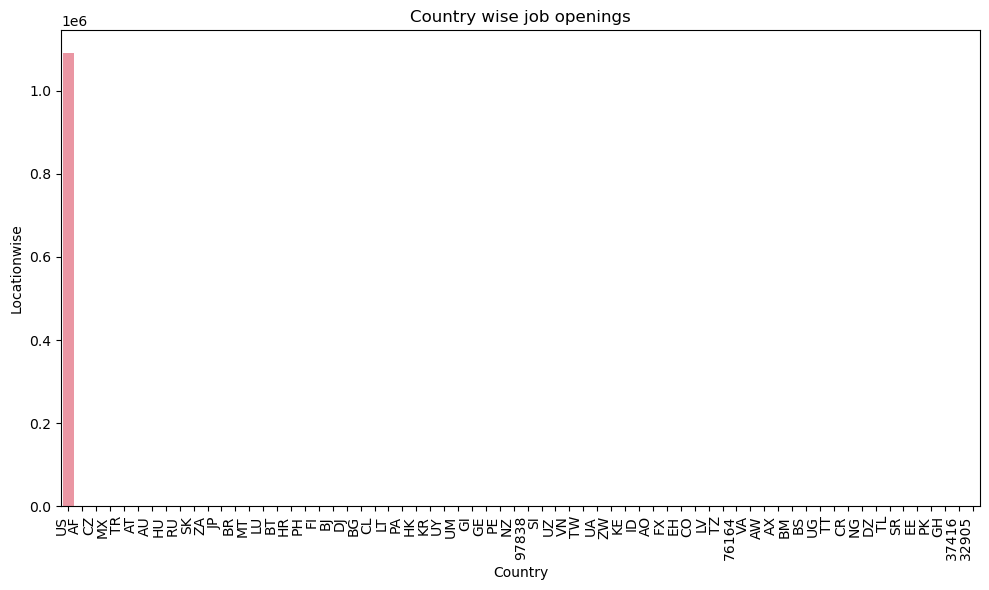

In [24]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Country", y="Locationwise", data=Country_wise_job)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Country wise job openings')
plt.tight_layout()
plt.show()

Since Most of the jobs are in use we will consider us region only and build model for us region only 

# Jobs in US region only

In [25]:
jobs_US = jobs.loc[jobs['Country']=='US']


In [26]:
jobs_US.shape

(1090462, 11)

In [27]:
jobs_US[['City','State','Country']]


,City,State,Country
0,Washington,DC,US
1,Charlotte,NC,US
2,Winter Park,FL,US
3,Orlando,FL,US
4,Orlando,FL,US
...,...,...,...
1091918,Amsterdam,NY,US
1091919,Birmingham,AL,US
1091920,Carthage,MS,US
1091921,Warren,MI,US


In [28]:
jobs_US.groupby(['City','State','Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head()

,City,State,Country,Locationwise
6601,Houston,TX,US,19306
9835,New York,NY,US,18395
2651,Chicago,IL,US,17806
3475,Dallas,TX,US,13139
610,Atlanta,GA,US,12352


# Statewise job opening in us

In [29]:
State_wise_job_US = jobs_US.groupby(['State']).size().reset_index(name=
                                                                       'Locationwise'
                                                                      ).sort_values('Locationwise',ascending=False)

In [30]:
State_wise_job_US.head()

,State,Locationwise
5,CA,109630
48,TX,98071
10,FL,71024
16,IL,58743
38,NY,53998


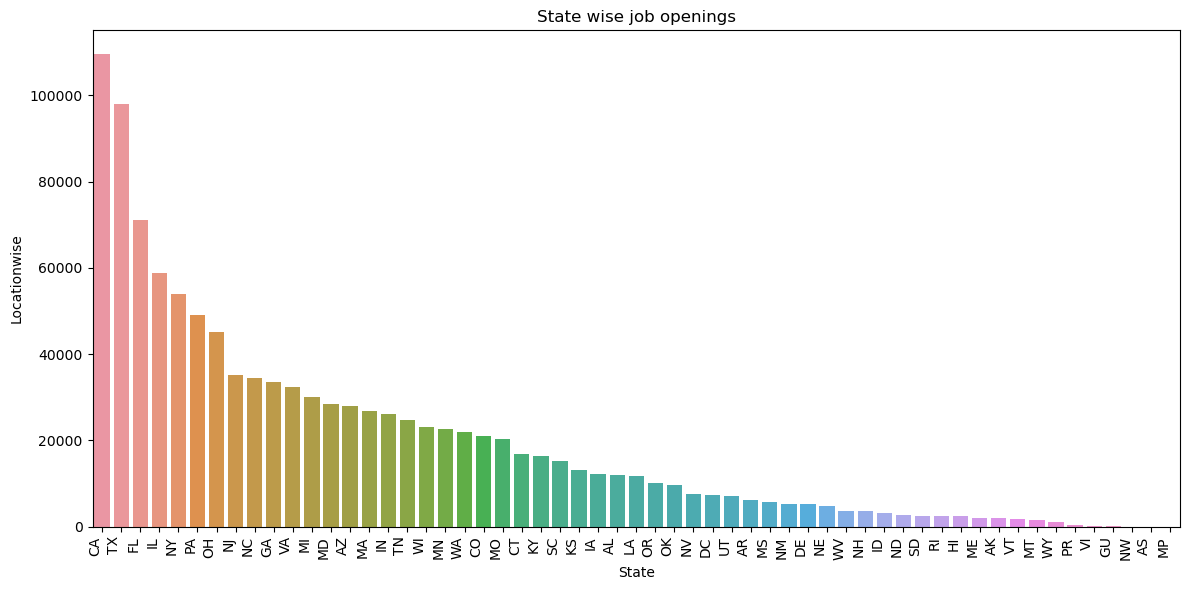

In [31]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x="State", y="Locationwise",data=State_wise_job_US)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job openings')
plt.tight_layout()
plt.show()

# Citywise job opening at us

In [32]:
City_wise_location = jobs_US.groupby(['City']).size().reset_index(
    name='Locationwise').sort_values('Locationwise',ascending=False)

In [33]:
City_wise_location_th = City_wise_location.loc[City_wise_location['Locationwise']>=12]
City_wise_location_th.head()


,City,Locationwise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365


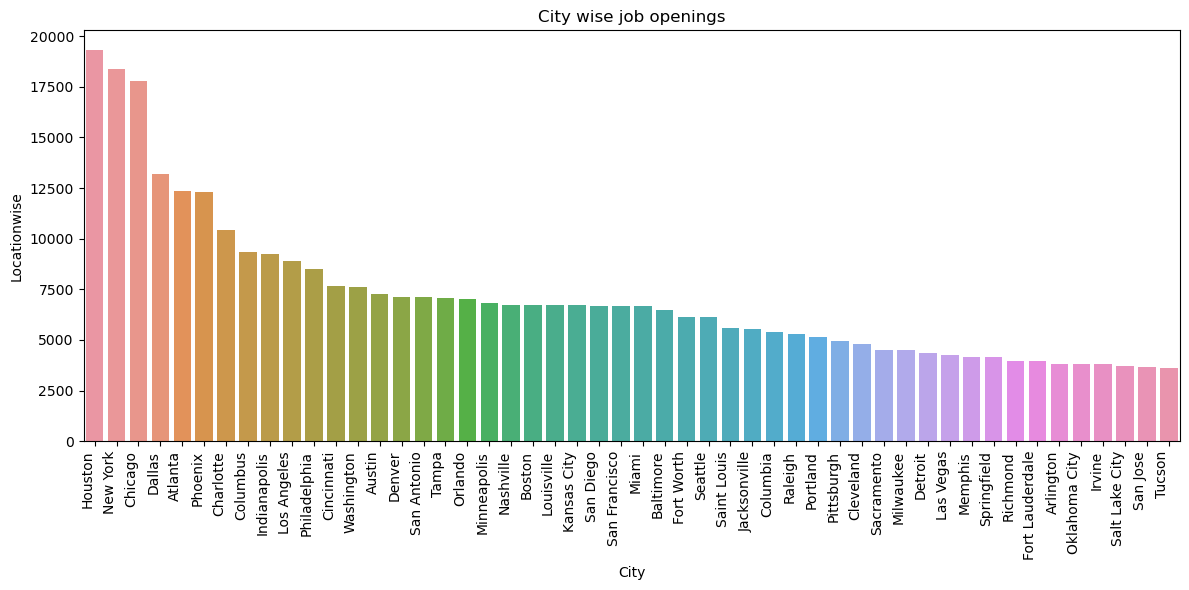

In [34]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x="City", y="Locationwise",data=City_wise_location_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('City wise job openings')
plt.tight_layout()
plt.show()


Insights:
When we do analysis state-wise then CA, TX, FL, IL and NY are having more job opening then other state
When we do analysis city-wise then Houston, New York, Chicago, Dallas, Atlanta and Phoenix are having more jobs compare to other cities
We have analyze the demand (job openings). Now there is time to analyze the supply(user-profiles)

# EDA for User profiles based on their location information


In [35]:
users_training.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                                        ascending=False).head()

,Country,Locationwise
105,US,365740
47,IN,236
18,CA,108
81,PH,59
82,PK,59


# Users looking jobs from us region countrywise

In [36]:
user_training_US = users_training.loc[users_training['Country']=='US']
user_training_US.shape

(365740, 15)

# Users looking jobs from us region Statewise

In [37]:
user_training_US_state_wise = user_training_US.groupby(['State']).size().reset_index(
    name='Locationwise_state').sort_values('Locationwise_state',ascending=False)
user_training_US_state_wise.head()


,State,Locationwise_state
11,FL,40381
47,TX,33260
6,CA,31141
17,IL,22557
37,NY,19299


In [38]:
user_training_US_th = user_training_US_state_wise.loc[user_training_US_state_wise['Locationwise_state']>=12]
user_training_US_th.head()


,State,Locationwise_state
11,FL,40381
47,TX,33260
6,CA,31141
17,IL,22557
37,NY,19299


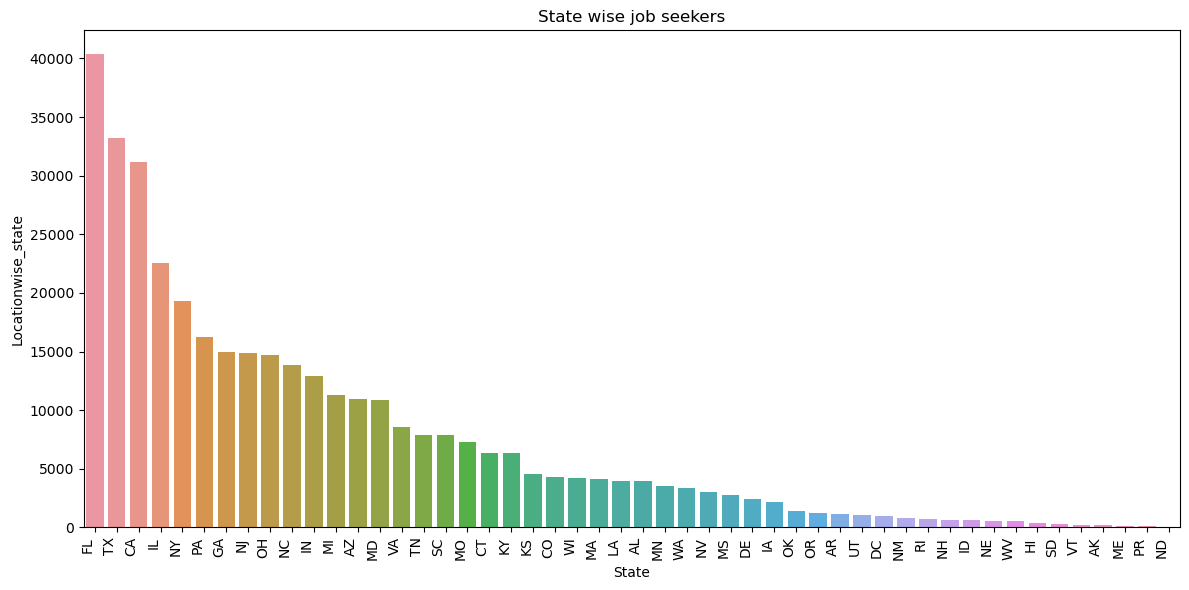

In [39]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x="State", y="Locationwise_state",data=user_training_US_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()


In [40]:
user_training_US_city_wise = user_training_US.groupby(['City']).size().reset_index(
    name='Locationwise_city').sort_values('Locationwise_city',ascending=False)

In [41]:
user_training_US_City_th = user_training_US_city_wise.loc[user_training_US_city_wise['Locationwise_city']>=12]
user_training_US_City_th.head()

,City,Locationwise_city
1528,Chicago,6964
4066,Houston,5487
4177,Indianapolis,4450
5604,Miami,4359
6965,Philadelphia,4347


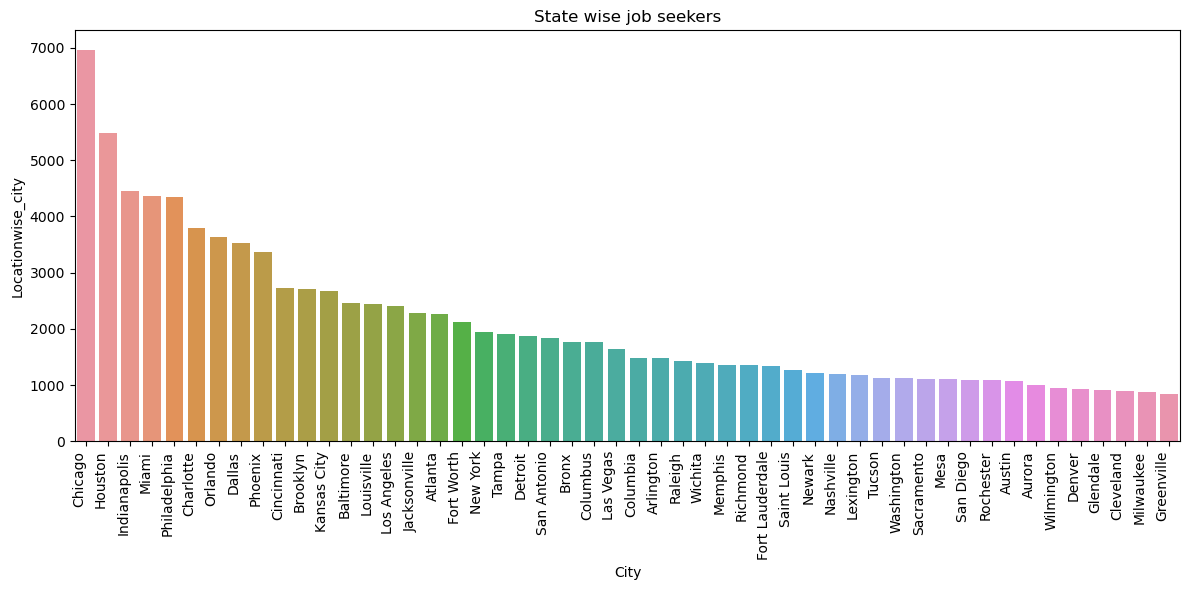

In [42]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x="City", y="Locationwise_city",data=user_training_US_City_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

Here note that we are going to consider the US region for our further analysis. We are not removing any data records right now.

Up-till now we have obtain the popular state and city for job seeker and job creator

Lets take 10000 rows for initial base model

In [43]:
jobs_US_base_line = jobs_US.iloc[:10000,:]

In [44]:
jobs_US_base_line = jobs_US.iloc[0:10000,0:8]
jobs_US_base_line.head()


,JobID,WindowID,Title,Description,Requirements,City,State,Country
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US


In [45]:
jobs_US_base_line['Title'] = jobs_US_base_line['Title'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Description'].fillna('')
jobs_US_base_line['Requirements'] = jobs_US_base_line['Requirements'].fillna('')

jobs_US_base_line['Description'] = jobs_US_base_line['Title'] + jobs_US_base_line['Description']

In [46]:
jobs_US_base_line['Description'][0]

'Security Engineer/Technical Lead<p>Security Clearance Required:&nbsp; Top Secret </p>\\r<p>Job Number: TMR-447</p>\\r<p>Location of Job:&nbsp; Washington, DC</p>\\r<p>TMR, Inc. is an Equal Employment Opportunity Company</p>\\r<p>For more job opportunities with TMR, visit our website <a href="http://www.tmrhq.com/">www.tmrhq.com</a></p>\\r<p>Send Resumes to HR@tmrhq2.com</p>\\r<p>&nbsp;</p>\\r<p>JOB SUMMARY:</p>\\r<p>&nbsp;</p>\\r<p>Leads the customer&rsquo;s overall Cyber Security strategy, formalizes service offerings consisted with ITIL best practices, and provides design and architecture support.</p>\\r<p>&nbsp;</p>\\r<ul>\\r    <li>Provide security design / architecture support for OJP&rsquo;s IT Security Division (ITSD) </li>\\r    <li>Leads the SECOPS team in the day to day OJP Security Operations support&nbsp; </li>\\r    <li>Provides direction when needed in a security incident or technical issues </li>\\r    <li>Works in concert with network operations on design /integration 

In [47]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(jobs_US_base_line['Description'])

In [48]:
tfidf_matrix.shape

(10000, 515343)

In [49]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


# Vectors for cosine similarity

In [50]:
cosine_sim

array([[1.        , 0.04300443, 0.00643851, ..., 0.03807697, 0.03807697,
        0.03807697],
       [0.04300443, 1.        , 0.00581514, ..., 0.02963034, 0.02963034,
        0.02963034],
       [0.00643851, 0.00581514, 1.        , ..., 0.02314751, 0.02314751,
        0.02314751],
       ...,
       [0.03807697, 0.02963034, 0.02314751, ..., 1.        , 1.        ,
        1.        ],
       [0.03807697, 0.02963034, 0.02314751, ..., 1.        , 1.        ,
        1.        ],
       [0.03807697, 0.02963034, 0.02314751, ..., 1.        , 1.        ,
        1.        ]])

In [51]:
jobs_US_base_line = jobs_US_base_line.reset_index()
titles = jobs_US_base_line['Title']
indices = pd.Series(jobs_US_base_line.index, index=jobs_US_base_line['Title'])

In [52]:
indices.head(30)

Title
Security Engineer/Technical Lead                0
SAP Business Analyst / WM                       1
P/T HUMAN RESOURCES ASSISTANT                   2
Route Delivery Drivers                          3
Housekeeping                                    4
SALON/SPA COORDINATOR                           5
SUPERINTENDENT                                  6
ELECTRONIC PRE-PRESS PROFESSIONAL               7
UTILITY LINE TRUCK OPERATOR/ DIGGER DERRICK     8
CONSTRUCTION PROJECT MGR & PM TRAINEE           9
Administrative Assistant                       10
ACCOUNT EXECUTIVES                             11
COMMERCIAL ESTIMATOR                           12
Immediate Opening                              13
TESL Adjunct                                   14
Salon Manager/Hairstylists                     15
VOCATIONAL COUNSELOR                           16
GALLERY SALES POSITIONS                        17
SURGICAL SCRUB TECH                            18
Real Estate Agent                           

### Program to find similar types of jobs based on title

In [53]:
def get_recommendations(title):
    idx = indices[title]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    job_indices = [i[0] for i in sim_scores]
    return pd.DataFrame(titles.iloc[job_indices].reset_index()["Title"])

In [54]:
get_recommendations("SAP Business Analyst / WM").head()

,Title
0,SAP Business Analyst / WM
1,SAP FI/CO Business Consultant
2,SAP FI/CO Business Analyst
3,SAP Basis Administrator
4,SAP Sales and Distribution Solution Architect


In [55]:
get_recommendations("SECURITY GUARDS").head(10).head()

,Title
0,SECURITY GUARDS
1,Security Guards - Part-Time Pool
2,Unarmed Security Guards
3,Senior Security Engineer
4,Oregon Licensed Security Guards Needed


# Second approach

Find out similar users -- Find out for which jobs they have applied -- suggest those job to the other users who shared similar user profile.
We are finding put similar user profile based on their degree type, majors and total years of experience.

We will get to 10 similar users.
We will find our which are the jobs for which these users have applied
We take an union of these jobs and recommend the jobs all these user base

In [47]:
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [48]:
user_based_approach_US = users_training.loc[users_training['Country']=='US']
user_based_approach = user_based_approach_US.iloc[0:10000,:]
user_based_approach

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10715,217816,1,Train,Phoenix,AZ,US,85023,Associate's,"Business Administration and Management, General",2013-06-01 00:00:00,3,8.0,No,No,0
10716,217826,1,Train,Orlando,FL,US,32801,PhD,Management,2012-01-01 00:00:00,8,5.0,No,No,0
10717,217841,1,Train,Mc Connells,SC,US,29726,Bachelor's,K-12 Choral/Instrumental MUSIC EDUCATION,2006-05-01 00:00:00,5,10.0,No,No,0
10718,217842,1,Train,Atlanta,GA,US,30311,Bachelor's,Accounting,NaN,6,13.0,Yes,No,0


In [49]:
user_based_approach.isna().sum()

UserID                     0
WindowID                   0
Split                      0
City                       0
State                      0
Country                    0
ZipCode                    5
DegreeType                 0
Major                   2626
GraduationDate          3421
WorkHistoryCount           0
TotalYearsExperience     559
CurrentlyEmployed       1393
ManagedOthers              0
ManagedHowMany             0
dtype: int64

Here we can see we have few columns  where we have missing values we have to fill it 

Becouse we are going to recommend on the base of eaduction  qualifications

In [50]:
user_based_approach['DegreeType'] = user_based_approach['DegreeType'].fillna('')
user_based_approach['Major'] = user_based_approach['Major'].fillna('')
user_based_approach['TotalYearsExperience'] = str(user_based_approach['TotalYearsExperience'].fillna(''))

user_based_approach['DegreeType'] = user_based_approach['DegreeType'] + user_based_approach['Major'] + user_based_approach['TotalYearsExperience']

In [51]:
print(user_based_approach['DegreeType'][1])

Master'sAnthropology0        10.0
1         8.0
2        11.0
3         3.0
4         9.0
         ... 
10715     8.0
10716     5.0
10717    10.0
10718    13.0
10719     6.0
Name: TotalYearsExperience, Length: 10000, dtype: object


In [52]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(user_based_approach['DegreeType'])

In [53]:
tfidf_matrix.shape


(10000, 7215)

## Cosine similarity

In [54]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [55]:
cosine_sim

array([[1.        , 0.17876394, 0.39845967, ..., 0.08851082, 0.27428073,
        0.19371807],
       [0.17876394, 1.        , 0.20047262, ..., 0.05471815, 0.16956271,
        0.11975817],
       [0.39845967, 0.20047262, 1.        , ..., 0.09925937, 0.30758876,
        0.21724275],
       ...,
       [0.08851082, 0.05471815, 0.09925937, ..., 1.        , 0.09895542,
        0.0698899 ],
       [0.27428073, 0.16956271, 0.30758876, ..., 0.09895542, 1.        ,
        0.21657751],
       [0.19371807, 0.11975817, 0.21724275, ..., 0.0698899 , 0.21657751,
        1.        ]])

In [56]:
user_based_approach = user_based_approach.reset_index()
userid = user_based_approach['UserID']
indices = pd.Series(user_based_approach.index, index=user_based_approach['UserID'])
indices.head(2)

UserID
47    0
72    1
dtype: int64

In [57]:
def get_recommendations_userwise(userid):
    idx = indices[userid]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    user_indices = [i[0] for i in sim_scores]
    #print (user_indices)
    return user_indices[0:11]


In [58]:
print ("-----Top 10 Similar users with userId: 123------")
get_recommendations_userwise(123)

-----Top 10 Similar users with userId: 123------


[4, 150, 1594, 5560, 1171, 2464, 2846, 7945, 8125, 2553, 5667]

In [59]:
def get_job_id(usrid_list):
    jobs_userwise = apps_training['UserID'].isin(usrid_list) #
    df1 = pd.DataFrame(data = apps_training[jobs_userwise], columns=['JobID'])
    joblist = df1['JobID'].tolist()
    Job_list = jobs['JobID'].isin(joblist) #[1083186, 516837, 507614, 754917, 686406, 1058896, 335132])
    df_temp = pd.DataFrame(data = jobs[Job_list], columns=['JobID','Title','Description','City','State'])
    return df_temp


In [61]:
print ("-----Top 10 Similar users with userId: 47------")
get_recommendations_userwise(47)

-----Top 10 Similar users with userId: 47------


[0, 79, 126, 182, 345, 366, 393, 423, 434, 490, 544]

In [62]:
get_job_id(get_recommendations_userwise(47))


,JobID,Title,Description,City,State
905894,428902,Aircraft Servicer,<b>Job Classification: </b> Direct Hire \r\n\r...,Memphis,TN
975525,1098447,Automotive Service Advisor,<div>\r<div>Briggs Nissan in Lawrence Kansas h...,Lawrence,KS
980507,37309,Medical Lab Technician - High Volume Lab,<span>Position Title:<span>&nbsp;&nbsp;&nbsp;&...,Fort Myers,FL
986244,83507,Nurse Tech (CNA/STNA),"<p align=""center""><b>Purpose of Your Job Posit...",Englewood,FL
987452,93883,Nurse Tech II (CNA/STNA),<B>Nurse Tech II (CNA/STNA)</B> <BR>\r<BR>\rTh...,Fort Myers,FL
1000910,228284,REGISTERED NURSE – ICU,"<p><strong><span><font face="""">Registered Nurs...",Punta Gorda,FL
1007140,284840,Certified Nursing Assistant / CNA,"<hr>\r<p style=""text-align: center""><strong>Ce...",Saint Petersburg,FL
1007141,284841,Home Health Aide / HHA,"<hr>\r<p style=""text-align: center""><strong>Ho...",Saint Petersburg,FL
1009455,312536,Secretary II,<br><br><b>Department: </b>COMM Maryland Cardi...,Baltimore,MD
1011978,341662,Medical Assistant,Certified Medical Assistant for busy Pain Clin...,Fort Myers,FL
